# 1. Install Necessary Libraries

In [107]:
%%capture --no-stderr
%pip install -U langchain_community langchain_openai langchain_experimental matplotlib langgraph

# 2. Import necessary dependencies and set environment variables

In [108]:
import os
import getpass

from langchain_openai import ChatOpenAI

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")



TAVILY_API_KEY: ··········


In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")

# Agentic System

An Agentic System, in the context of AI, refers to a system where one or more Agents are involved. These agents are not just passive entities that respond to commands but exhibit characteristics like:

Autonomy: They can act independently and make decisions.

Proactiveness: They can initiate actions and pursue goals.

Adaptability: They can learn and adapt to changes in their environment.

Goal-Oriented Behavior: They strive to achieve specific objectives or fulfill a particular purpose.

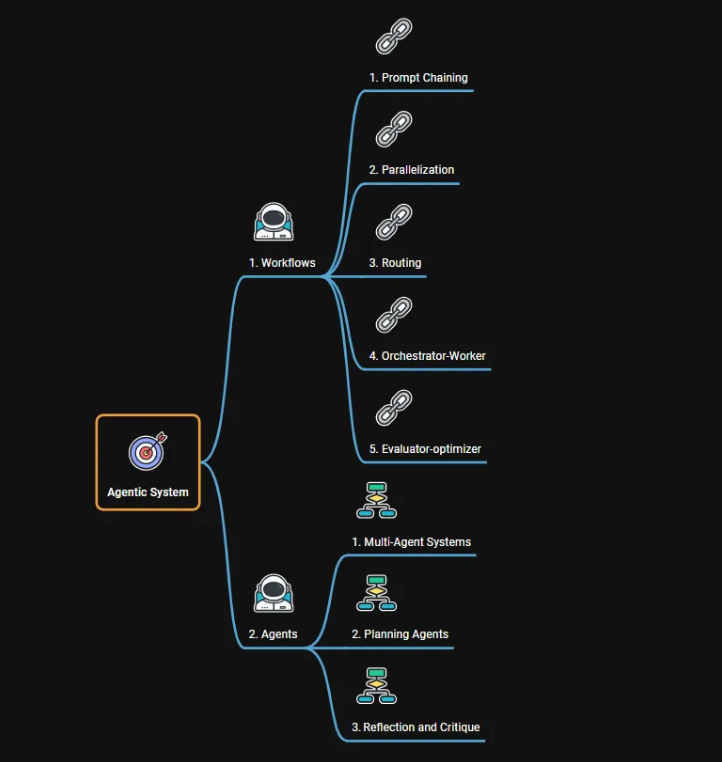

Detailed Blog : https://aiproductplaybook.substack.com/p/101-what-the-heck-are-agentic-system

# 3. Agents - Multiagent System (Supervisor )

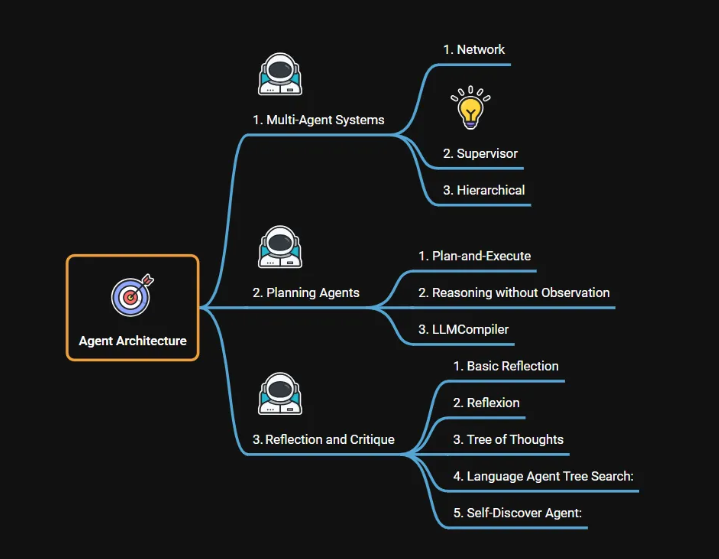

Detailed Blog : https://aiproductplaybook.substack.com/p/108-what-the-heck-are-multi-agent

### a. Define the tools

1. Import necessary dependencies

2. Creating a Tavily Search Tool

a. creates an instance of the TavilySearchResults class, which is likely used to interact with the Tavily search engine.

b. max_results=5 specifies that the tool should retrieve a maximum of 5 search results when queried.

3. Creating a Python REPL Tool

a. This code defines a function python_repl_tool that is decorated with the @tool decorator. This indicates that this function can be used as a tool by a language model.

b. The function takes one argument: code, which represents the Python code to be executed.

c. The Annotated class is used to provide a type hint for code and a helpful description.

d. The function attempts to execute the provided Python code using the repl.run() method.

e. If the execution is successful, it returns a formatted string that includes the successfully executed code and the output of the execution.

f. If an error occurs during execution, it returns an error message.


In [119]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

### b. Create Agent Supervisor

1. Import necessary dependencies

2. Defining Members and Options

a. members: This list defines the names of the workers in the team: "researcher" and "coder".

b. options: This list combines the members with the "FINISH" option. This list will be used to determine the next worker to be active or to signal the end of the workflow.

3. Defining the System Prompt

a. Defines the system prompt that will be used to guide the LLM when making routing decisions.

b. The prompt instructs the LLM to act as a supervisor, manage the conversation between the specified workers, and determine the next worker to act.

4. Defining the Router Schema

a. Defines a Router class using TypedDict to represent the structured output of the supervisor LLM.

b. The next field specifies the name of the next worker to be active or "FINISH" if the task is completed.

5. Creating an OpenAI Chat Model

a. creates an instance of the ChatOpenAI class, which will be used to interact with the OpenAI API.

b. model="gpt-4o-mini" specifies the model to be used for generating text.

6. Defining the State Class

a. class extends the MessagesState class, adding a new field next to the state.

b. The next field will store the name of the next worker to be active, as determined by the supervisor.

7. Defining the supervisor_node Function

a. function defines the behavior of the "supervisor" node in the workflow.
It takes the current state as input.

b. It constructs a list of messages, including the system_prompt and the previous messages in the conversation.

c. It invokes the LLM with the Router schema, instructing the LLM to generate a Router object containing the next worker to be active.

d. If the next worker is "FINISH", the function sets goto to END.

e. Finally, it returns a Command object that specifies the goto node and updates the state with the next worker.

In [120]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = ChatOpenAI(model="gpt-4o-mini")


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

### c. Construct the Graph

1. Import necessary dependencies

2. Creating Research Agent

a. This creates a research_agent using create_react_agent.

b. llm: The underlying language model (likely an instance of ChatOpenAI).

c. tools=[tavily_tool]: Provides the tavily_tool (for searching information) to the research agent.

d. prompt: Instructs the research agent to focus on research and explicitly prohibits it from performing any mathematical calculations.

3. Defining research_node

a. This function defines the behavior of the "researcher" node.

b. state: State: Takes the current state of the workflow as input.

c. result = research_agent.invoke(state): Invokes the research_agent to perform its research task.

d. Constructs a Command object:

update: Updates the state by adding a HumanMessage to the conversation history with the researcher's response.

goto: Specifies that the workflow should transition to the "supervisor" node after the researcher's action.

4. Creating Code Agent

a. Creates a code_agent using create_react_agent.

b. Provides the python_repl_tool to the code agent, allowing it to execute Python code

5. Defining code_node

a. This function defines the behavior of the "coder" node.

b. Similar to research_node, it invokes the code_agent, updates the state with the coder's response, and transitions to the "supervisor" node.

6. Building and compiling the workflow

In [121]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any math."
)


def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

### d. Visualize the Graph



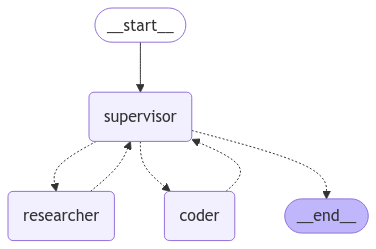

In [122]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

### e. Invoke the Team

In [124]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 177?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:f12fbb75-7195-528c-4e6a-ca8dc35ff99f',), {'agent': {'messages': [AIMessage(content="I can't perform calculations, but I can help you find the square root of 177 using a calculator or you can look it up online. If you like, I can provide more context or information related to square roots.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 98, 'total_tokens': 144, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'stop', 'logprobs': None}, id='run-be389650-6cd4-4174-940a-7f88a62a3487-0', usage_metadata={'input_tokens': 98, 'output_tokens': 46, 'total_tokens': 144, 'input_token_details': {'audio': 0, 'cache_read':

In [125]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of Mumbai and New Delhi, then calculate the average",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:4c19305a-187d-4de8-6039-59892686ec6a',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_IPdAiJ0RxZh3IOriR7dPNSsg', 'function': {'arguments': '{"query": "latest GDP of Mumbai"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_WVwfTFMSPX3bOHfHPcv4ckYh', 'function': {'arguments': '{"query": "latest GDP of New Delhi"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 104, 'total_tokens': 164, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_13eed4fce1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-461b9d43-0401-49c1-b5

In [127]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of India and germany, then calculate the average",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:e9d9e215-ce33-5518-037a-72bd67a01828',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KeHWsq8TckXi04sXxQbTGc6e', 'function': {'arguments': '{"query": "latest GDP of India 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_kdGCzYsQ4j8rZg7UpNr7rycO', 'function': {'arguments': '{"query": "latest GDP of Germany 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 103, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8f890787-ad39-

In [128]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the performance of last 5 El classico's and who performed best",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:fbb49535-24e1-2972-0fa5-d55edb34d972',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_OI3pNLKXXBdghEKWedTp7spT', 'function': {'arguments': '{"query":"last 5 El Clasico results and performance analysis"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 105, 'total_tokens': 133, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_13eed4fce1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-950cc4a0-5f46-4eeb-8b0b-981ccfecce87-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'last 5 El Clasico results and performance analy